<a href="https://colab.research.google.com/github/A-Midhat/Covid-NPI-Effectiveness/blob/main/BGDMS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpyro

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

import jax
import jax.numpy as jnp
from jax.experimental.ode import odeint
from jax import random
from numpyro.handlers import condition, seed


In [ ]:
numpyro.set_platform('cpu')

# Working

In [ ]:
!unzip "/content/COVID19_Dataset.zip"


Archive:  /content/COVID19_Dataset.zip
replace time-series-19-covid-combined.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
#Reading the dataset
ts = pd.read_csv("/content/time-series-19-covid-combined.csv")
ts["Country/Region"].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'Guatemala', 'Guin

In [ ]:
#Selecting UK
selected_country = "United Kingdom"
country = ts[ts["Country/Region"] == selected_country]
country.head()

,Date,Country/Region,Province/State,Lat,Long,Confirmed,Recovered,Deaths
66690,2020-01-22,United Kingdom,Anguilla,18.2206,-63.0686,0,0.0,0
66691,2020-01-23,United Kingdom,Anguilla,18.2206,-63.0686,0,0.0,0
66692,2020-01-24,United Kingdom,Anguilla,18.2206,-63.0686,0,0.0,0
66693,2020-01-25,United Kingdom,Anguilla,18.2206,-63.0686,0,0.0,0
66694,2020-01-26,United Kingdom,Anguilla,18.2206,-63.0686,0,0.0,0


In [ ]:
#Merging the data from multiple UK provinces
dates = ts["Date"].unique()
new_cases = list(ts["Confirmed"])
UK_daily_cases = []
UK_data=ts[ts['Country/Region']==selected_country]
sum(new_cases)
for date in dates:
    UK_daily_cases.append(UK_data[UK_data['Date']==date]['Confirmed'].sum())

new_cases = [0]
for i in range(1,len(UK_daily_cases)):
  new_cases.append(UK_daily_cases[i]-UK_daily_cases[i-1])


In [ ]:
#Obtaining the active cases fromthe total confirmed cases and the daily new cases
active_cases = UK_daily_cases[0:14]
for i in range(14,len(UK_daily_cases)):
  active_cases.append(UK_daily_cases[i]-new_cases[i-14])

In [ ]:
active_cases=active_cases[9:] #Non-zero actice cases start at index 9


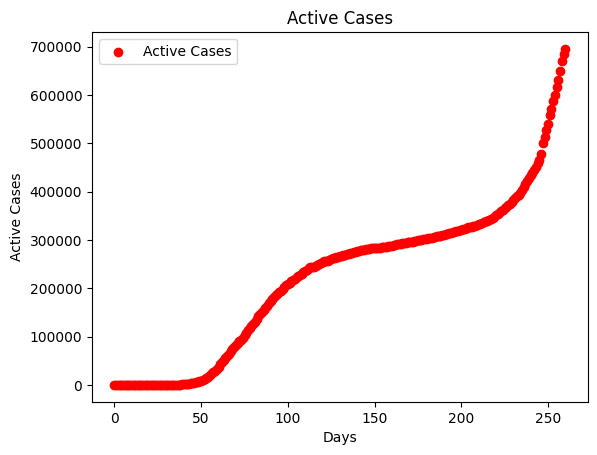

In [ ]:
#plotting active cases
plt.scatter(range(len(active_cases)), active_cases, label="Active Cases", color="red")
# plt.plot(range(len(dates)), new_cases, label="New", color="green")

plt.xlabel("Days")
plt.ylabel("Active Cases")
plt.title("Active Cases")
plt.legend()
plt.show()

In [ ]:
#Basic SIR model function
def SIR(beta, gamma, S0, I0, R0, N, time):

    S = np.zeros(time)
    I = np.zeros(time)
    R = np.zeros(time)

    #System initial conditions
    S[0] = S0
    I[0] = I0
    R[0] = R0

    for t in range(1, time):
        S[t] = S[t - 1] - S[t - 1] * I[t - 1] / N
        I[t] = I[t - 1] + S[t - 1] * I[t - 1] / N - gamma * I[t - 1]
        R[t] = R[t - 1] + gamma * I[t - 1]

    return S, I, R


In [ ]:
# SIRQV model function
def SIR2(beta, gamma, theta , alphaa, S0, I0, R0, V0, H0, N, time):

    S = np.zeros(time)
    I = np.zeros(time)
    R = np.zeros(time)
    V = np.zeros(time)
    H = np.zeros(time)

    #System initial conditions
    S[0] = S0
    I[0] = I0
    R[0] = R0
    V[0] = V0
    H[0] = H0

    for t in range(1, time):
        S[t] = S[t - 1] - S[t - 1] * I[t - 1] / N- theta*S[t - 1]
        I[t] = I[t - 1] + S[t - 1] * I[t - 1] / N - gamma * I[t - 1]- alphaa*I[t-1]
        R[t] = R[t - 1] + gamma * I[t - 1]
        V[t] = V[t - 1] + theta*S[t - 1]
        H[t] = H[t - 1] + alphaa*I[t-1]

    return S, I, R,V,H

sample: 100%|██████████| 1500/1500 [00:24<00:00, 60.41it/s, 15 steps of size 2.40e-01. acc. prob=0.91] 


Mean beta: 0.23904792964458466
Mean gamma: 0.0649099126458168


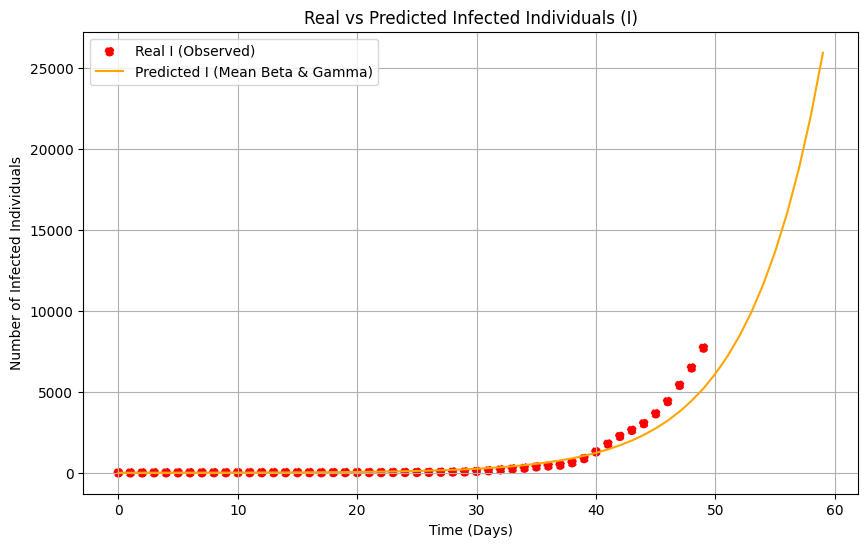

In [ ]:
def SIR(beta, gamma, S0, I0, R0, N, time):

    S = np.zeros(time)
    I = np.zeros(time)
    R = np.zeros(time)

    #System initial conditions
    S[0] = S0
    I[0] = I0
    R[0] = R0

    for t in range(1, time):
        S[t] = S[t - 1] - S[t - 1] * I[t - 1] / N
        I[t] = I[t - 1] + S[t - 1] * I[t - 1] / N - gamma * I[t - 1]
        R[t] = R[t - 1] + gamma * I[t - 1]

    return S, I, R

def SIR_fit(time, N):

    beta = numpyro.sample("beta", dist.Uniform(1,20 ))
    gamma = numpyro.sample("gamma", dist.Uniform(0, 1))

    S0 = N - 1  # One initial infected individual
    I0 = 1
    R0 = 0

    S = jnp.zeros(time)
    I = jnp.zeros(time)
    R = jnp.zeros(time)

    S = S.at[0].set(S0)
    I = I.at[0].set(I0)
    R = R.at[0].set(R0)

    for t in range(1, time):
        S = S.at[t].set(S[t - 1] - beta*S[t - 1] * I[t - 1] / N)
        I = I.at[t].set(I[t - 1] + beta*S[t - 1] * I[t - 1] / N - gamma * I[t - 1])
        R = R.at[t].set(R[t - 1] + gamma * I[t - 1])

    # Observed data likelihood
    numpyro.sample("obs", dist.Normal(I, 0.1), obs=None)

# Simulate some data
T = 50
N = 68_000_000


observed_I = active_cases[0:50]

# Run inference
def model(obs=None):
    numpyro_sir(T=T, N=N)

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, obs=observed_I)

# Posterior analysis
posterior_samples = mcmc.get_samples()
#print(posterior_samples)
# Calculate the mean of beta and gamma

# Calculate the mean of beta and gamma
mean_beta = posterior_samples['beta'].mean()
mean_gamma = posterior_samples['gamma'].mean()


print(f"Mean beta: {mean_beta}")
print(f"Mean gamma: {mean_gamma}")
SS,II,RR=sir_model(mean_beta, mean_gamma, 68_000_000-2, 2, 0, 68_000_000, 1000)

import matplotlib.pyplot as plt

# Plot the observed (real) and predicted I values
plt.figure(figsize=(10, 6))

# Plot real I values (observed data)
plt.scatter(range(50), active_cases[0:50], label="Real I (Observed)", color="red", linestyle="--")

# Plot predicted I values (using mean beta and gamma)
plt.plot(range(60), II[0:60], label="Predicted I (Mean Beta & Gamma)", color="orange")

# Add labels, title, and legend
plt.xlabel("Time (Days)")
plt.ylabel("Number of Infected Individuals")
plt.title("Real vs Predicted Infected Individuals (I)")
plt.legend()
plt.grid()

# Show the plot
plt.show()


sample: 100%|██████████| 1500/1500 [00:19<00:00, 75.42it/s, 15 steps of size 2.40e-01. acc. prob=0.91] 


Mean beta: 0.25
Mean gamma: 0.07


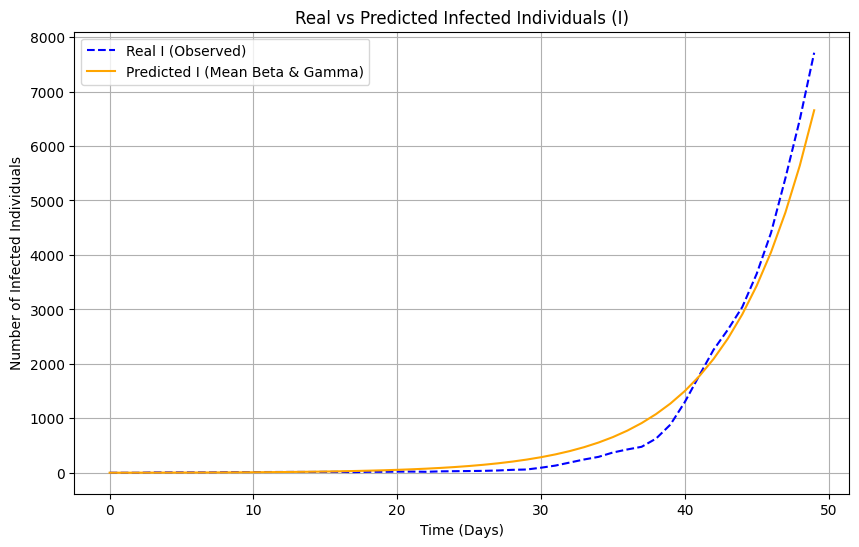

In [ ]:
import numpy as np
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.handlers import condition, seed
from numpyro.infer import MCMC, NUTS



def numpyro_sir(T, N):

    beta = numpyro.sample("beta", dist.Uniform(0.22,0.26 ))
    gamma = numpyro.sample("gamma", dist.Uniform(0.05,0.08))

    S0 = N - 2  # One initial infected individual
    I0 = 2
    R0 = 0

    S = jnp.zeros(T)
    I = jnp.zeros(T)
    R = jnp.zeros(T)

    S = S.at[0].set(S0)
    I = I.at[0].set(I0)
    R = R.at[0].set(R0)

    for t in range(1, T):
        new_infected = beta * S[t - 1] * I[t - 1] / N
        new_recovered = gamma * I[t - 1]
        S = S.at[t].set(S[t - 1] - new_infected)
        I = I.at[t].set(I[t - 1] + new_infected - new_recovered)
        R = R.at[t].set(R[t - 1] + new_recovered)

    # Observed data likelihood
    numpyro.sample("obs", dist.Exponential(I), obs=None)

# Simulate some data
T = 50
N = 68_000_000


observed_I = active_cases[0:50]

# Run inference
def model(obs=None):
    numpyro_sir(T=T, N=N)

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, obs=observed_I)

# Posterior analysis
posterior_samples = mcmc.get_samples()
#print(posterior_samples)
# Calculate the mean of beta and gamma


print(f"Mean beta: {mean_beta}")
print(f"Mean gamma: {mean_gamma}")


In [ ]:
#Predict cases based on estimated parameters
SS,II,RR=sir_model(mean_beta, mean_gamma, 68_000_000-2, 2, 0, 68_000_000, 60)


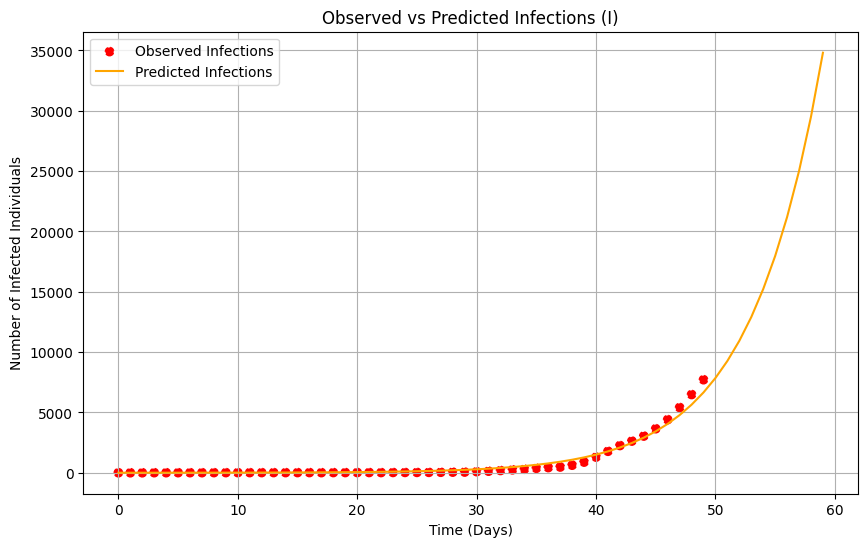

In [ ]:
#plot predictions
import matplotlib.pyplot as plt

# Plot the observed (real) and predicted I values
plt.figure(figsize=(10, 6))

# Plot real I values (observed data)
plt.scatter(range(50), active_cases[0:50], label="Observed Infections", color="red", linestyle="--")

# Plot predicted I values (using mean beta and gamma)
plt.plot(range(60), II[0:60], label="Predicted Infections", color="orange")

# Add labels, title, and legend
plt.xlabel("Time (Days)")
plt.ylabel("Number of Infected Individuals")
plt.title("Observed vs Predicted Infections (I)")
plt.legend()
plt.grid()

# Show the plot
plt.show()


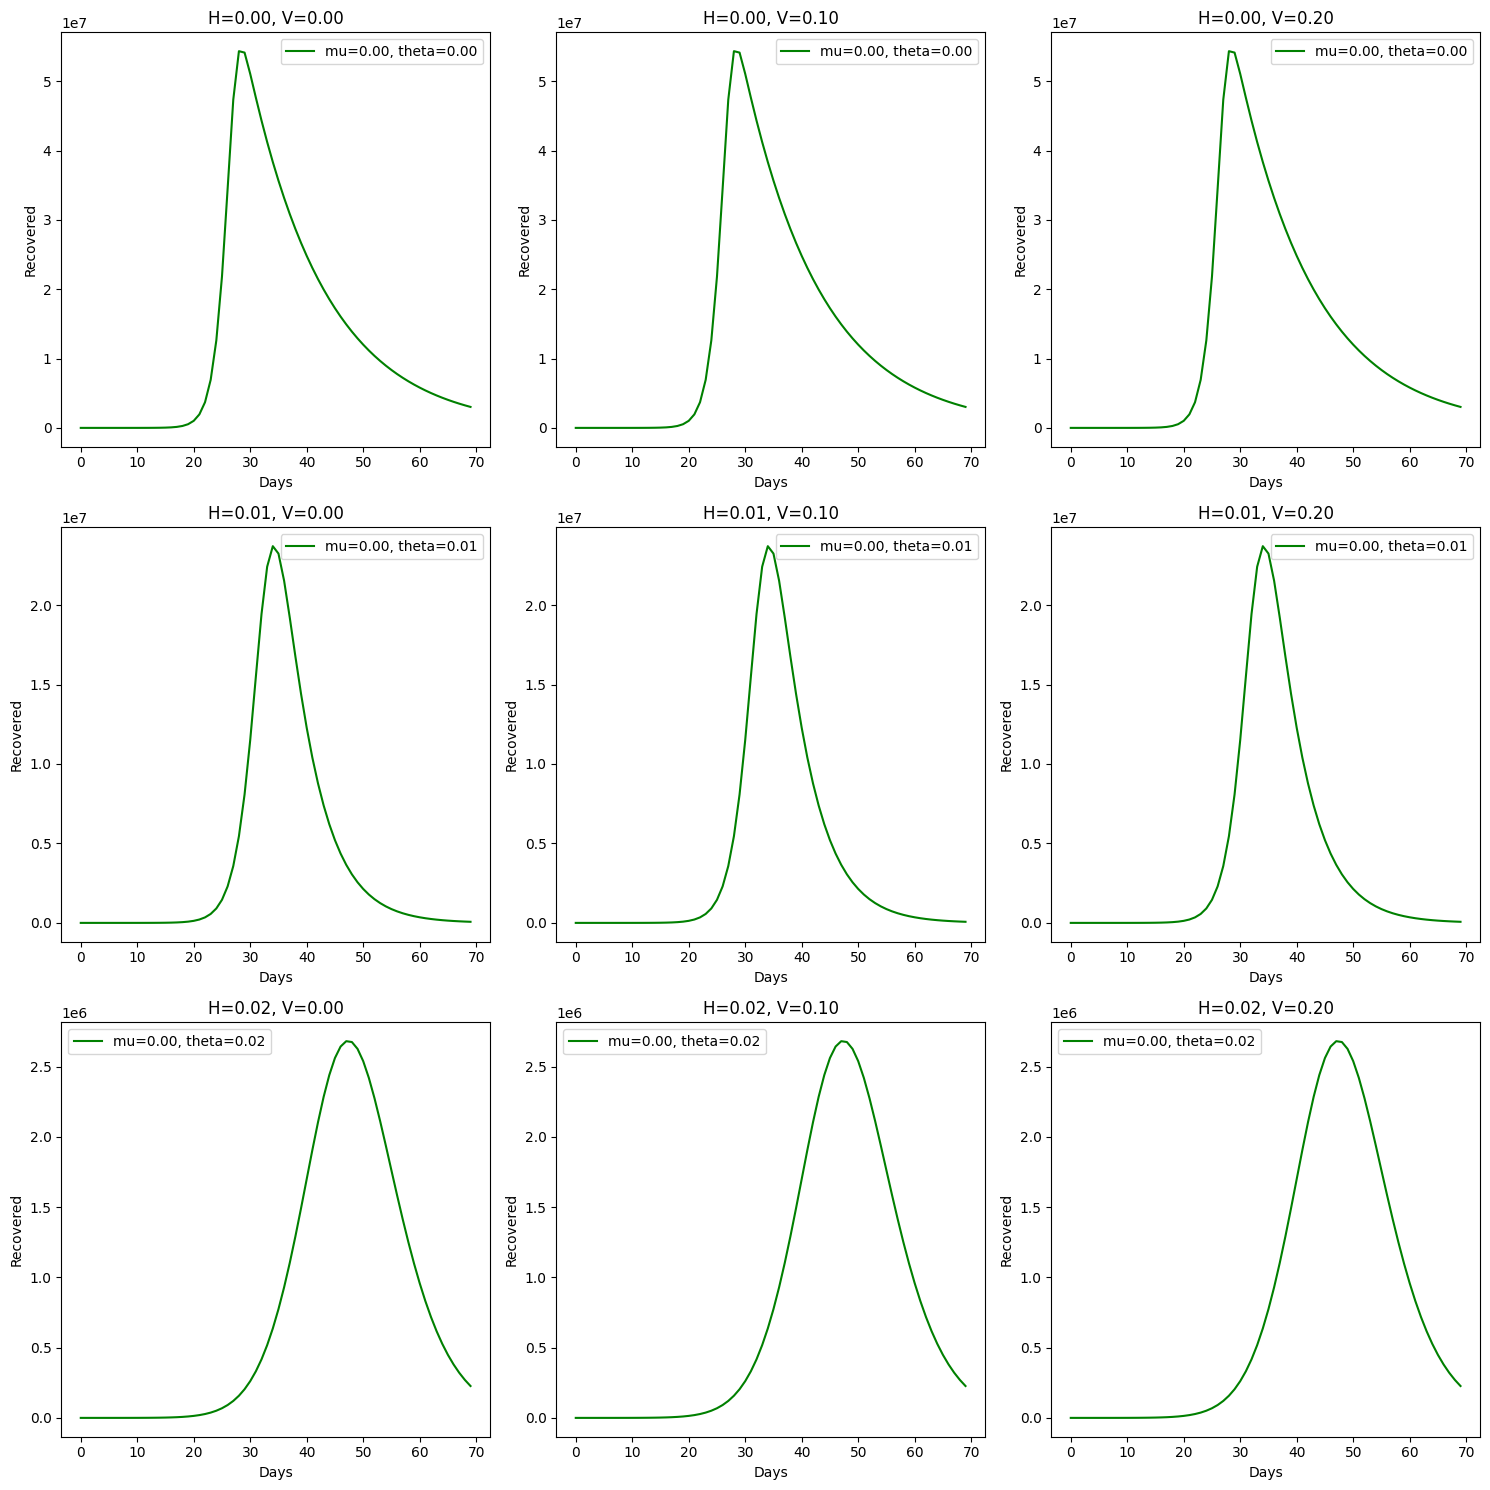

In [ ]:
#Simulate quarantine and vaccination

mu = 0.0
theta = 0.0
simulated_I = []

theta = [0,  0.01,  0.02]
alphaa=[0,0.1, 0.2]
fig, ax = plt.subplots(3, 3, figsize=(15, 15))

for m in range(3):
    for t in range(3):
        _, I, _, _, _ = SIR2(mean_beta, mean_gamma, theta[m] , alphaa[m], 68_000_000, 2, 0, 0, 0, 68_000_000, 70)
        #ax[m, t].scatter(range(len(df['in_bed'])), df['in_bed'], color='blue', alpha=0.5, label='Infected')
        ax[m, t].plot(range(70), I, color="green",  label=f"mu={mu:.2f}, theta={theta[m]:.2f}")
        ax[m, t].legend()
        ax[m, t].set_xlabel("Days")
        ax[m, t].set_ylabel("Recovered")
        ax[m, t].set_title( f"H={theta[m]:.2f}, V={alphaa[t]:.2f}")


plt.tight_layout()
plt.show()
